# Predict expression modulation targets

Cameo provides algorithms to search for genes or reactions that can be over or down regulated in order to achieve a given biological objective.

In [1]:
from cobra.io import read_sbml_model

Load the E. coli core model.

In [2]:
model = read_sbml_model('data/e_coli_core.xml.gz')

## Succinate production

The production envelope looks like this.

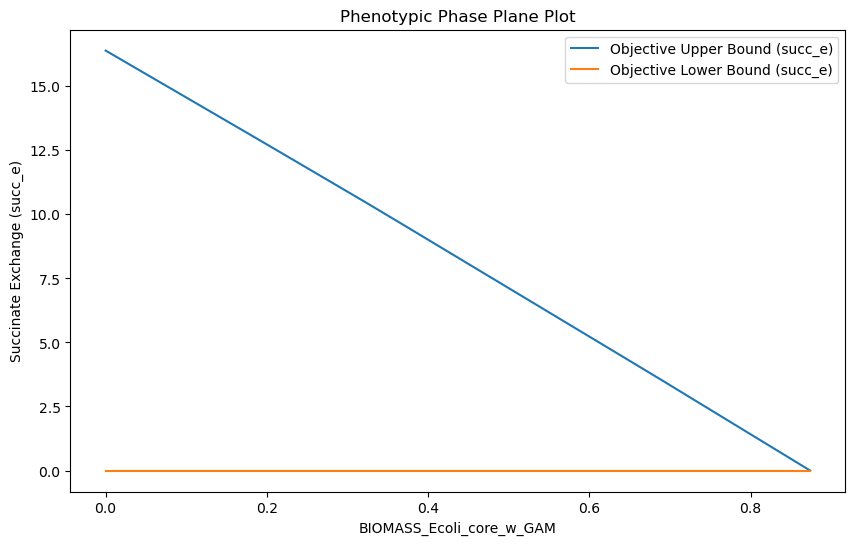

In [5]:
from cameo.flux_analysis.analysis import phenotypic_phase_plane
import matplotlib.pyplot as plt

production_envelope = phenotypic_phase_plane(model, 
                                             variables=[model.reactions.BIOMASS_Ecoli_core_w_GAM],
                                             objective=model.metabolites.succ_e)

# Extract data from the production envelope
df = production_envelope.data_frame

# Plot BIOMASS vs Objective (succ_e)
plt.figure(figsize=(10, 6))
plt.plot(df['BIOMASS_Ecoli_core_w_GAM'], df['objective_upper_bound'], label='Objective Upper Bound (succ_e)')
plt.plot(df['BIOMASS_Ecoli_core_w_GAM'], df['objective_lower_bound'], label='Objective Lower Bound (succ_e)')

# Add labels and title
plt.xlabel('BIOMASS_Ecoli_core_w_GAM')
plt.ylabel('Succinate Exchange (succ_e)')
plt.title('Phenotypic Phase Plane Plot')
plt.legend()

# Show the plot
plt.show()

## Flux Scanning based on Enforced Objective Flux

In [6]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [7]:
fseof = FSEOF(model)

In [8]:
result = fseof.run(target=model.reactions.EX_succ_e)

In [9]:
result.data_frame

,1,2,3,4,5,6,7,8,9,10
ADK1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.410338,1.527283
ENO,15.238892,15.761645,16.212407,16.577535,16.942662,17.307790,17.704415,18.602292,19.293292,19.628048
FBA,7.756941,8.036499,8.242515,8.361048,8.479582,8.598115,8.747793,9.393102,9.830787,9.910940
FRD7,0.000000,0.000000,0.000000,1.453235,3.175302,4.897369,6.586703,7.755141,9.127842,10.852285
GAPD,16.431132,16.838737,17.173618,17.421989,17.670359,17.918730,18.198431,18.976723,19.547784,19.761991
ICL,0.000000,0.000000,0.386057,1.231342,2.076627,2.921912,3.735322,4.041459,4.143333,3.893465
MALS,0.000000,0.000000,0.386057,1.231342,2.076627,2.921912,3.735322,4.041459,4.143333,3.893465
PDH,8.809270,8.336008,8.179868,8.400957,8.622045,8.843134,9.064539,9.290984,9.107760,8.219084
PFK,7.756941,8.036499,8.242515,8.361048,8.479582,8.598115,8.747793,9.393102,9.830787,9.910940
PGI,5.485630,6.110399,6.513173,6.651876,6.790579,6.929282,7.161108,8.874882,9.965126,9.981645


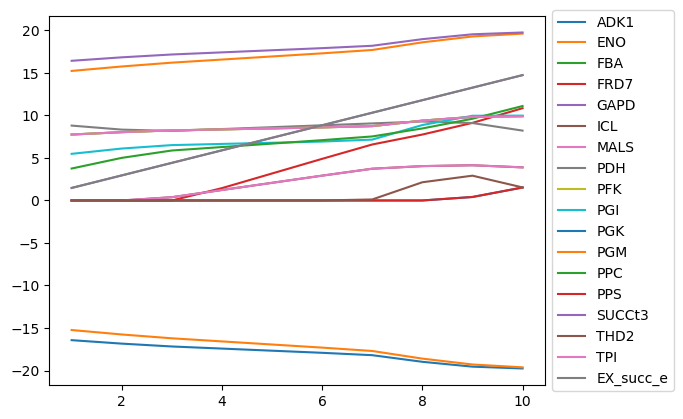

In [10]:
from matplotlib import pyplot as plt
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Differential flux variability analysis

Compares flux ranges of a reference model to a set of models that have been parameterized to lie on a grid of evenly spaced points in the n-dimensional production envelope (n being the number of reaction bounds to be varied).

In [11]:
from cameo.strain_design.deterministic import DifferentialFVA

Set up a model that represents a reference state (in this case a model with a constrained growth rate).

In [12]:
model.reactions.EX_o2_e.lower_bound = 0
reference_model = model.copy()
biomass_rxn = reference_model.reactions.BIOMASS_Ecoli_core_w_GAM
biomass_rxn.lower_bound = 0.
target = reference_model.metabolites.succ_e

Set up the differential flux variability analysis strain design method.

In [13]:
diff_fva = DifferentialFVA(design_space_model=model,
                           reference_model=reference_model,
                           objective=target,
                           variables=[biomass_rxn],
                           normalize_ranges_by=biomass_rxn,
                           points=10)

Run differential flux variability analysis (only on the surface of the production envelope)

HBox()

CPU times: user 450 ms, sys: 5.37 ms, total: 455 ms
Wall time: 450 ms


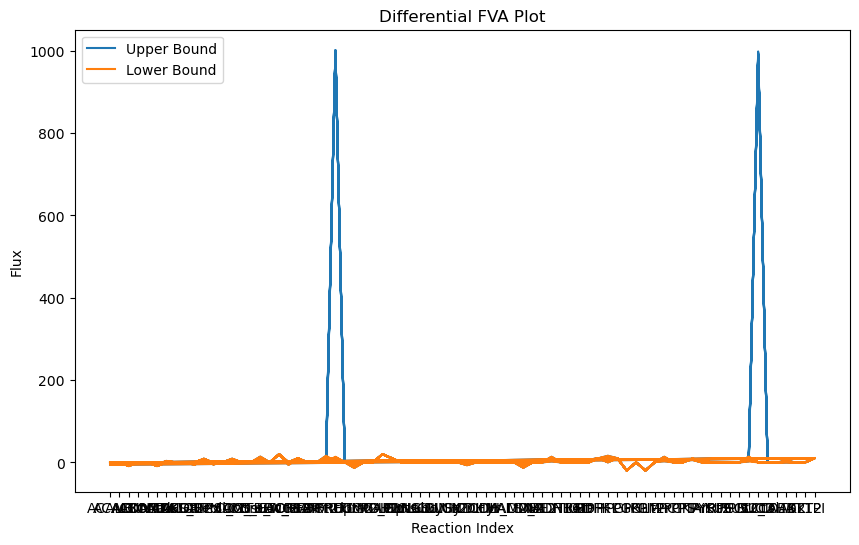

In [20]:
%time result = diff_fva.run(surface_only=True)

import matplotlib.pyplot as plt

# Extract data from the result object
df = result.data_frame
plt.figure(figsize=(10, 6))

# Plot upper and lower bounds of fluxes
plt.plot(df.index, df['upper_bound'], label='Upper Bound')
plt.plot(df.index, df['lower_bound'], label='Lower Bound')

# Add labels and title
plt.xlabel('Reaction Index')
plt.ylabel('Flux')
plt.title('Differential FVA Plot')
plt.legend()

# Show the plot
plt.show()

In [25]:
result

,lower_bound,upper_bound,gaps,normalized_gaps,biomass,production,KO,flux_reversal,suddenly_essential,free_flux,reaction,excluded
reaction,,,,,,,,,,,,
H2Ot,-1.794362,-1.794362,-8.910158e+00,-52.692787,0.094072,9.873904,False,True,False,False,H2Ot,False
PYK,0.000000,0.000000,-8.404273e+00,-39.705924,0.094072,9.873904,True,False,False,False,PYK,False
ACALD,0.000000,0.000000,-8.279455e+00,-39.116224,0.094072,9.873904,True,False,False,False,ACALD,False
ALCD2x,0.000000,0.000000,-8.279455e+00,-39.116224,0.094072,9.873904,True,False,False,False,ALCD2x,False
ETOHt2r,0.000000,0.000000,-8.279455e+00,-39.116224,0.094072,9.873904,True,False,False,False,ETOHt2r,False
PFL,7.873216,7.873216,-9.931458e+00,-0.424913,0.094072,9.873904,False,False,False,False,PFL,False
FORti,7.873216,7.873216,-9.931458e+00,-0.424913,0.094072,9.873904,False,False,False,False,FORti,False
PPS,0.583116,0.583116,5.831156e-01,6.198581,0.094072,9.873904,False,False,False,False,PPS,False
ADK1,0.583116,0.583116,5.831156e-01,6.198581,0.094072,9.873904,False,False,False,False,ADK1,False


In [26]:
result.display_on_map(5, map_name="iJO1366.Central metabolism")

Builder(reaction_data={'ACALD': -34.432100701203495, 'ACKr': 37.79593929879677, 'ACt2r': 37.79593929879677, 'A…